In [1]:
import pandas as pd

from mlutils.preprocessing import preprocessing
from mlutils.tensorflowutils import tensorflowutils

In [2]:
from importlib import reload

reload(preprocessing)
reload(tensorflowutils)

<module 'mlutils.tensorflowutils.tensorflowutils' from '/home/alessiosavi/anaconda3/envs/ml/lib/python3.9/site-packages/mlutils/tensorflowutils/tensorflowutils.py'>

In [4]:
df = pd.read_csv(
    "dataset/jena_climate_2009_2016.zip", compression="zip", low_memory=False
)
# delete same features
for feature in [
    "Tpot (K)",
    "Tdew (degC)",
    "VPmax (mbar)",
    "VPdef (mbar)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]:
    del df[feature]

In [5]:
df.head()

,Date Time,p (mbar),T (degC),rh (%),VPact (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3)
0,01.01.2009 00:10:00,996.52,-8.02,93.3,3.11,1.94,3.12,1307.75
1,01.01.2009 00:20:00,996.57,-8.41,93.4,3.02,1.89,3.03,1309.80
2,01.01.2009 00:30:00,996.53,-8.51,93.9,3.01,1.88,3.02,1310.24
3,01.01.2009 00:40:00,996.51,-8.31,94.2,3.07,1.92,3.08,1309.19
4,01.01.2009 00:50:00,996.51,-8.27,94.1,3.08,1.92,3.09,1309.00


In [6]:
def set_time_index(
    df: pd.DataFrame, col_name: str, time_format: str = None
) -> pd.DataFrame:
    if col_name not in df.columns:
        raise Exception("Column {} is not in dataset: {}".format(col_name, df.columns))
    try:
        if time_format != None:
            df.index = pd.to_datetime(df[col_name], format=time_format)
        else:
            df.index = pd.to_datetime(df[col_name])
    except Exception as e:
        print("Unable to set {} as time index: {}".format(col_name, e))
    return df


df = set_time_index(df, "Date Time", time_format="%d.%m.%Y %H:%M:%S")
df.info(verbose=True, memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420551 entries, 2009-01-01 00:10:00 to 2017-01-01 00:00:00
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   rh (%)           420551 non-null  float64
 4   VPact (mbar)     420551 non-null  float64
 5   sh (g/kg)        420551 non-null  float64
 6   H2OC (mmol/mol)  420551 non-null  float64
 7   rho (g/m**3)     420551 non-null  float64
dtypes: float64(7), object(1)
memory usage: 28.9+ MB


In [7]:
# interval-> Seconds to resample
def resample_df(df: pd.DataFrame, interval: int) -> pd.DataFrame:
    # Time interval is the number of seconds between each misuration
    time_interval = df.index.to_series().diff().dt.seconds.mode()[0]
    # These misuration break the rule, resample to `time_interval`
    df[df.index.to_series().diff().dt.seconds > time_interval]
    # Take only the integer part
    time_interval = str(int(time_interval))
    df = df.resample(time_interval + "S").mean().ffill().interpolate()
    assert (df.index.to_series().diff().dt.seconds > float(time_interval)).sum() == 0
    df = df.resample("{}".format(interval) + "S").mean().ffill().interpolate()
    assert (df.index.to_series().diff().dt.seconds > float(interval)).sum() == 0
    return df


import numpy as np

In [8]:
# Resample to 1 day
df = resample_df(df, 86400)
# df.reset_index(inplace=True)
df.info(verbose=True, memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2009-01-01 to 2017-01-01
Freq: 86400S
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p (mbar)         2923 non-null   float64
 1   T (degC)         2923 non-null   float64
 2   rh (%)           2923 non-null   float64
 3   VPact (mbar)     2923 non-null   float64
 4   sh (g/kg)        2923 non-null   float64
 5   H2OC (mmol/mol)  2923 non-null   float64
 6   rho (g/m**3)     2923 non-null   float64
dtypes: float64(7)
memory usage: 182.7 KB


In [9]:
from tsfresh import select_features

In [10]:
X_filtered = select_features(df, df["T (degC)"].values,n_jobs=7,show_warnings=True)

/home/alessiosavi/anaconda3/envs/ml/lib/python3.9/site-packages/tsfresh/feature_selection/relevance.py:337: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  table_binary["p_value"] = pd.Series(


In [11]:
X_filtered

,T (degC),VPact (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),rh (%)
Date Time,,,,,,
2009-01-01,-6.810629,3.355524,2.091049,3.357832,1305.178252,91.086014
2009-01-02,-3.728194,4.267292,2.659792,4.268750,1290.353194,92.086806
2009-01-03,-5.271736,3.107708,1.937778,3.111944,1297.117014,76.458056
2009-01-04,-1.375208,4.938958,3.114028,4.997014,1264.634514,89.417361
2009-01-05,-4.867153,3.806736,2.397014,3.847778,1284.372778,86.260417
...,...,...,...,...,...,...
2016-12-28,4.887153,7.269583,4.473264,7.171875,1266.425556,84.070833
2016-12-29,2.676250,6.705833,4.123889,6.613542,1277.391528,90.384722
2016-12-30,-1.706597,5.048542,3.113889,4.996875,1294.402639,92.927083


In [12]:
df

,p (mbar),T (degC),rh (%),VPact (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3)
Date Time,,,,,,,
2009-01-01,999.145594,-6.810629,91.086014,3.355524,2.091049,3.357832,1305.178252
2009-01-02,999.600625,-3.728194,92.086806,4.267292,2.659792,4.268750,1290.353194
2009-01-03,998.548611,-5.271736,76.458056,3.107708,1.937778,3.111944,1297.117014
2009-01-04,988.510694,-1.375208,89.417361,4.938958,3.114028,4.997014,1264.634514
2009-01-05,990.405694,-4.867153,86.260417,3.806736,2.397014,3.847778,1284.372778
...,...,...,...,...,...,...,...
2016-12-28,1013.542986,4.887153,84.070833,7.269583,4.473264,7.171875,1266.425556
2016-12-29,1013.957569,2.676250,90.384722,6.705833,4.123889,6.613542,1277.391528
2016-12-30,1010.460278,-1.706597,92.927083,5.048542,3.113889,4.996875,1294.402639


In [13]:
df.info(verbose=True, memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2009-01-01 to 2017-01-01
Freq: 86400S
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p (mbar)         2923 non-null   float64
 1   T (degC)         2923 non-null   float64
 2   rh (%)           2923 non-null   float64
 3   VPact (mbar)     2923 non-null   float64
 4   sh (g/kg)        2923 non-null   float64
 5   H2OC (mmol/mol)  2923 non-null   float64
 6   rho (g/m**3)     2923 non-null   float64
dtypes: float64(7)
memory usage: 182.7 KB


In [14]:
X_filtered.describe()

,T (degC),VPact (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),rh (%)
count,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000
mean,9.438695,9.531888,6.021181,9.638261,1216.123823,76.043056
std,7.836859,4.073540,2.584967,4.122177,37.374443,11.375917
min,-16.457292,1.312917,0.810625,1.302014,1134.728472,37.580347
25%,3.811007,6.301354,3.983056,6.388125,1188.102813,67.691319
50%,9.708333,8.938056,5.626528,9.014861,1212.219167,76.988472
75%,15.419062,12.307778,7.764340,12.424028,1240.976806,84.577604
max,29.375347,23.749722,15.101667,24.056806,1367.595417,100.000000


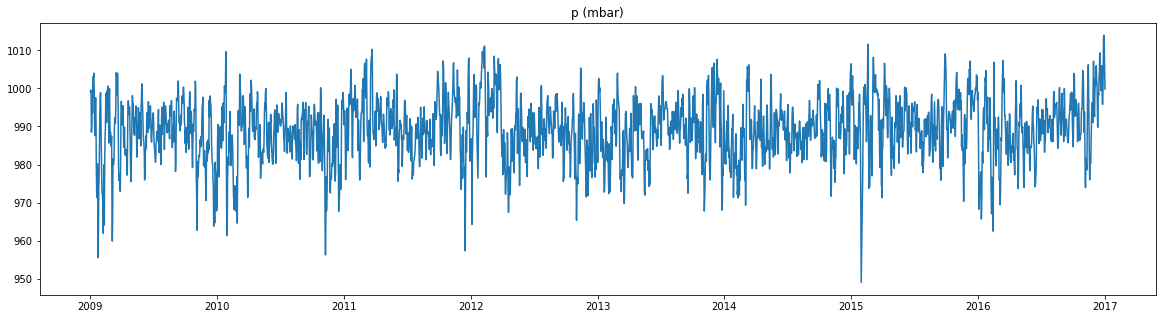

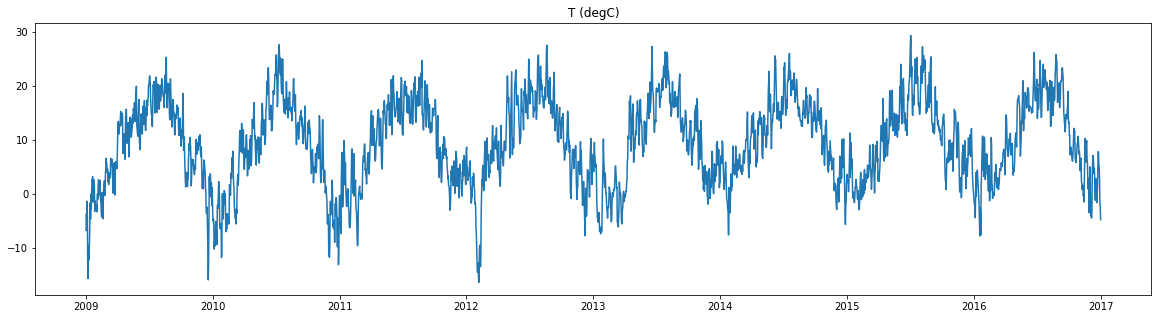

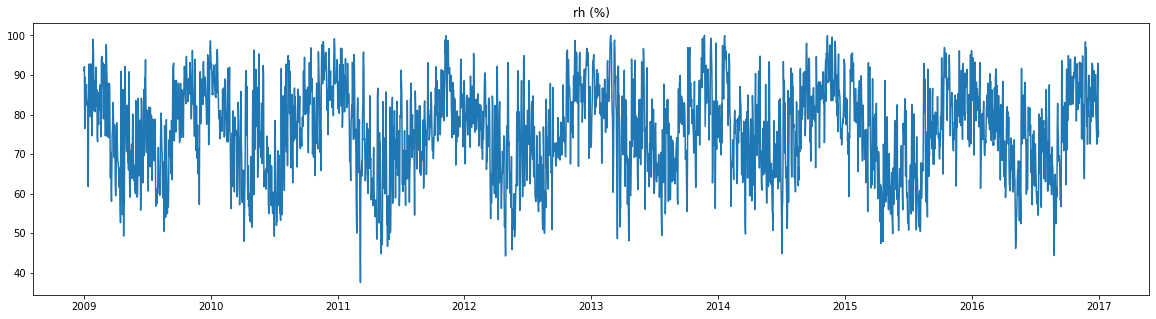

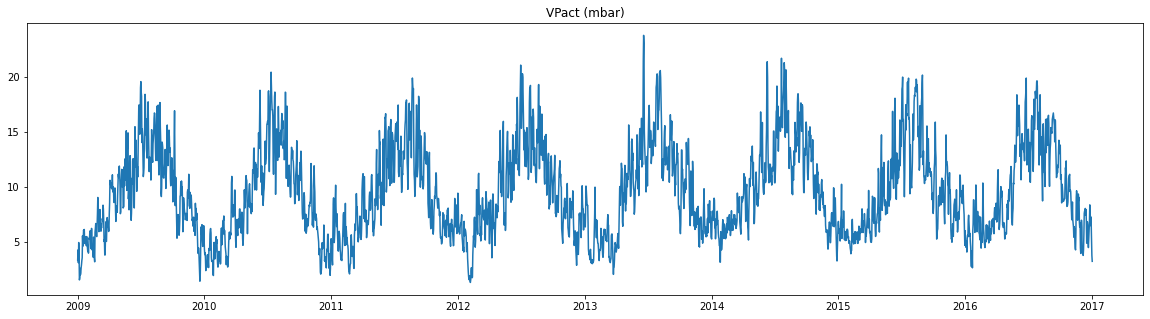

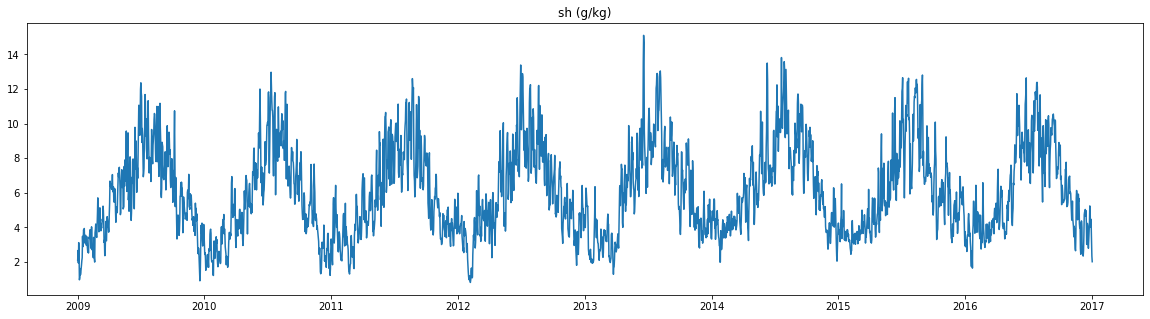

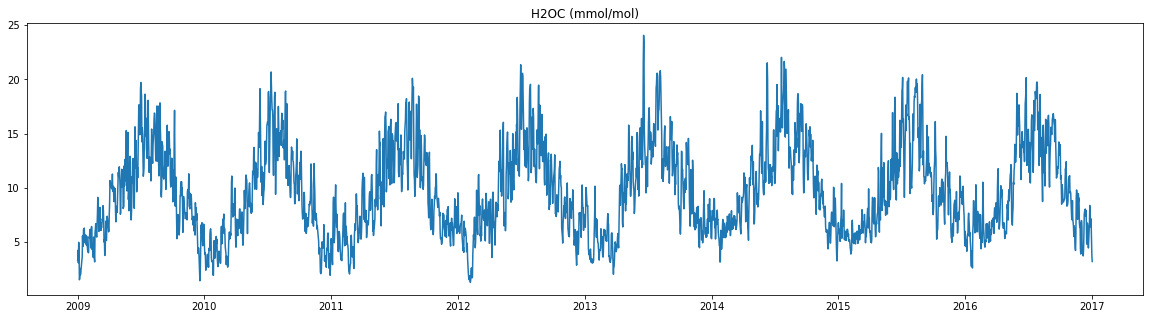

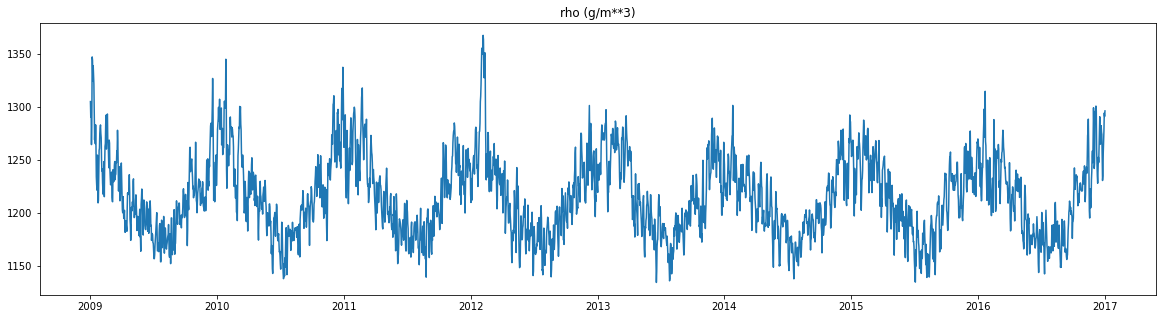

In [15]:
import matplotlib.pyplot as plt

for i in df.columns:
    plt.figure(figsize=(20, 5))
    plt.title(i)
    plt.plot(df[i])

# TENSORFLOW

In [16]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 Ti, compute capability 7.5


2021-11-24 22:23:27.461759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 22:23:27.465863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 22:23:27.466102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 22:23:27.466371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Scale data

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = {}
columns = {}
for column in df.columns:
    sc = StandardScaler()
    scaler[column] = sc
    df_scaled = sc.fit_transform(df[column].to_numpy().reshape(-1, 1))
    columns[column] = df_scaled.ravel()
# df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

<AxesSubplot:>

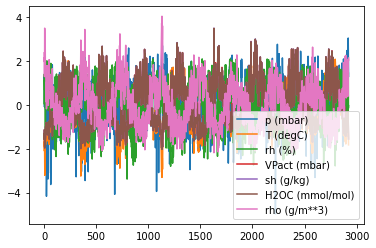

In [38]:
df_scaled = pd.DataFrame(columns)
df_scaled.plot()

In [39]:
numpy_x = df_scaled.values
# numpy_x = df.values
# numpy_x = numpy_x.reshape(numpy_x.shape[0], 1)
numpy_x.shape

(2923, 7)

In [40]:
numpy_x.shape

(2923, 7)

In [41]:
import numpy as np


def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [42]:
# Use 370 days as history, predict 7 days
history_window = 370
n_prediction = 7
n_features = numpy_x.shape[1]
df_x, df_y = split_sequence(numpy_x, history_window, n_prediction)

In [43]:
def get_predict_columns(df: pd.DataFrame, feature_name: str) -> int:
    for i in range(len(df.columns)):
        if df.columns[i] == feature_name:
            return i
    raise Exception("No column found")


feature_to_predict = get_predict_columns(df, "T (degC)")

In [44]:
df_y = df_y[:, :, feature_to_predict]

In [45]:
df_x.shape, df_y.shape

((2547, 370, 7), (2547, 7))

In [46]:
# Reshaping into n_example, timestamps, features
df_x = df_x.reshape(df_x.shape[0], df_x.shape[1], n_features)
df_x.shape

(2547, 370, 7)

In [47]:
# Reshaping in n_example, timestamps
df_y = df_y.reshape(df_y.shape[0], df_y.shape[1])
df_y.shape

(2547, 7)

In [48]:
example_conf = """
{
    "model_type": "Sequential",
    "input_shape": [
        370,
        7
    ],
    "model_conf": [
        {
            "layer": "LSTM",
            "layer_conf": {"units": 1024, "return_sequences": true }
        },
        {
            "layer": "LSTM",
            "layer_conf": {"units": 512,"return_sequences": true}
        },
        {
            "layer": "LSTM",
            "layer_conf": {"units": 256}
        },
        {
            "layer": "DENSE",
            "layer_conf": {"units": 7}
        }
    ],
    "compile_conf": {
        "optimizer": "adam",
        "loss": "mse",
        "metrics": "mae"
    }
}
"""

In [49]:
import json

c = json.loads(example_conf)
callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=10, restore_best_weights=True
)

model = tensorflowutils.train_model(
    c, df_x[:-1], df_y[:-1], epochs=1000, callbacks=[callback], batch_size=256
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 370, 1024)         4227072   
                                                                 
 lstm_7 (LSTM)               (None, 370, 512)          3147776   
                                                                 
 lstm_8 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 8,164,103
Trainable params: 8,164,103
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 5s 176ms/step - loss: 0.4824 - mae: 0.5449
Epoch 2/1000
10/10 [==============================] - 2s 183ms/step - loss: 0.2

INFO:tensorflow:Assets written to: model_dir/LSTM_LSTM_LSTM_DENSE/7/assets


INFO:tensorflow:Assets written to: model_dir/LSTM_LSTM_LSTM_DENSE/7/assets


In [50]:
# Reshape input in order to have a single example with `history_window` timestamp
model_input = df_x[-1].reshape(1, history_window, n_features)

In [51]:
model_prediction = model.predict(model_input).ravel()

In [52]:
d = {
    "real_values": scaler["T (degC)"]
    .inverse_transform(df_y[-1].reshape(-1, 1))
    .ravel(),
    "model_values": scaler["T (degC)"]
    .inverse_transform(model_prediction.reshape(-1, 1))
    .ravel(),
}

<AxesSubplot:>

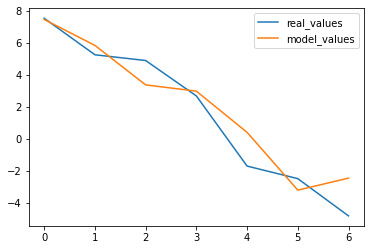

In [53]:
pd.DataFrame(d).plot()

In [36]:
model.save("my_model.h5")
model = tf.keras.models.load_model("my_model.h5")